Rumusan Masalah B

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, classification_report, 
                           confusion_matrix, roc_curve)
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data (pastikan path sesuai dengan file Anda)
df_news = pd.read_csv(r'D:\SKRIPSI\skripsi_2025\fix_dataset\berita_combined_2020-2024.csv')
df_news['tanggal'] = pd.to_datetime(df_news['date'], format= '%d/%m/%Y')

# Persiapan data
df_news['lemmatized_text'] = df_news['stemmed_text']
X_text = df_news['lemmatized_text']  # Atau gunakan 'stemmed_text'
y = df_news['label'].map({'positif': 1, 'negatif': 0})

# Stopwords
stopword_factory = StopWordRemoverFactory()
stopword_list = stopword_factory.get_stop_words()

# Split data dengan stratifikasi untuk distribusi kelas yang seimbang
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

print(f"✅ Total data: {len(df_news):,} berita")
print(f"✅ Data training: {len(X_train):,} berita")
print(f"✅ Data testing: {len(X_test):,} berita")
print(f"✅ Distribusi kelas:")
print(f"   - Positif: {(y == 1).sum():,} ({(y == 1).mean()*100:.1f}%)")
print(f"   - Negatif: {(y == 0).sum():,} ({(y == 0).mean()*100:.1f}%)")

✅ Total data: 1,332 berita
✅ Data training: 1,065 berita
✅ Data testing: 267 berita
✅ Distribusi kelas:
   - Positif: 644 (48.3%)
   - Negatif: 688 (51.7%)


In [3]:
# Model terbaik: ComplementNB dengan parameter optimal
best_model = Pipeline([
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2), 
        max_features=3500, 
        min_df=3, 
        max_df=0.92,
        sublinear_tf=True, 
        stop_words=stopword_list
    )),
    ('classifier', ComplementNB(alpha=0.5))
])

print("✅ Model yang digunakan: ComplementNB + TF-IDF")
print("✅ Parameter optimal:")
print("   - ngram_range: (1, 2)")
print("   - max_features: 3500")
print("   - min_df: 3, max_df: 0.92")
print("   - alpha: 0.5")

✅ Model yang digunakan: ComplementNB + TF-IDF
✅ Parameter optimal:
   - ngram_range: (1, 2)
   - max_features: 3500
   - min_df: 3, max_df: 0.92
   - alpha: 0.5


In [4]:
# Training model
best_model.fit(X_train, y_train)

# Prediksi
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

In [5]:
# Hitung semua metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_proba)

# Tampilkan hasil evaluasi
print("PERFORMA SISTEM PREDIKSI SENTIMEN:")
print(f"Akurasi       : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision     : {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall        : {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score      : {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")
print(f"ROC AUC Score : {roc_auc:.4f} ({roc_auc*100:.2f}%)")

# Interpretasi performa
print(f"\nINTERPRETASI PERFORMA:")
if accuracy >= 0.70:
    print(f"EXCELLENT: Akurasi {accuracy*100:.1f}% menunjukkan sistem sangat baik")
elif accuracy >= 0.60:
    print(f"GOOD: Akurasi {accuracy*100:.1f}% menunjukkan sistem cukup baik")
else:
    print(f"FAIR: Akurasi {accuracy*100:.1f}% perlu perbaikan")

if roc_auc >= 0.80:
    print(f"ROC AUC {roc_auc:.3f} menunjukkan kemampuan diskriminasi sangat baik")
elif roc_auc >= 0.70:
    print(f"ROC AUC {roc_auc:.3f} menunjukkan kemampuan diskriminasi baik")

PERFORMA SISTEM PREDIKSI SENTIMEN:
Akurasi       : 0.7004 (70.04%)
Precision     : 0.7021 (70.21%)
Recall        : 0.7004 (70.04%)
F1-Score      : 0.6987 (69.87%)
ROC AUC Score : 0.7369 (73.69%)

INTERPRETASI PERFORMA:
EXCELLENT: Akurasi 70.0% menunjukkan sistem sangat baik
ROC AUC 0.737 menunjukkan kemampuan diskriminasi baik


In [6]:
# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Hitung metrics detail per kelas
precision_pos = tp / (tp + fp) if (tp + fp) > 0 else 0
precision_neg = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_pos = tp / (tp + fn) if (tp + fn) > 0 else 0
recall_neg = tn / (tn + fp) if (tn + fp) > 0 else 0

print("CONFUSION MATRIX:")
print(f"True Negative  (TN): {tn:3d} | False Positive (FP): {fp:3d}")
print(f"False Negative (FN): {fn:3d} | True Positive  (TP): {tp:3d}")

print(f"\nMETRICS PER KELAS:")
print(f"Sentimen NEGATIF:")
print(f"- Precision: {precision_neg:.4f} ({precision_neg*100:.2f}%)")
print(f"- Recall   : {recall_neg:.4f} ({recall_neg*100:.2f}%)")
print(f"Sentimen POSITIF:")
print(f"- Precision: {precision_pos:.4f} ({precision_pos*100:.2f}%)")
print(f"- Recall   : {recall_pos:.4f} ({recall_pos*100:.2f}%)")

CONFUSION MATRIX:
True Negative  (TN): 106 | False Positive (FP):  32
False Negative (FN):  48 | True Positive  (TP):  81

METRICS PER KELAS:
Sentimen NEGATIF:
- Precision: 0.6883 (68.83%)
- Recall   : 0.7681 (76.81%)
Sentimen POSITIF:
- Precision: 0.7168 (71.68%)
- Recall   : 0.6279 (62.79%)


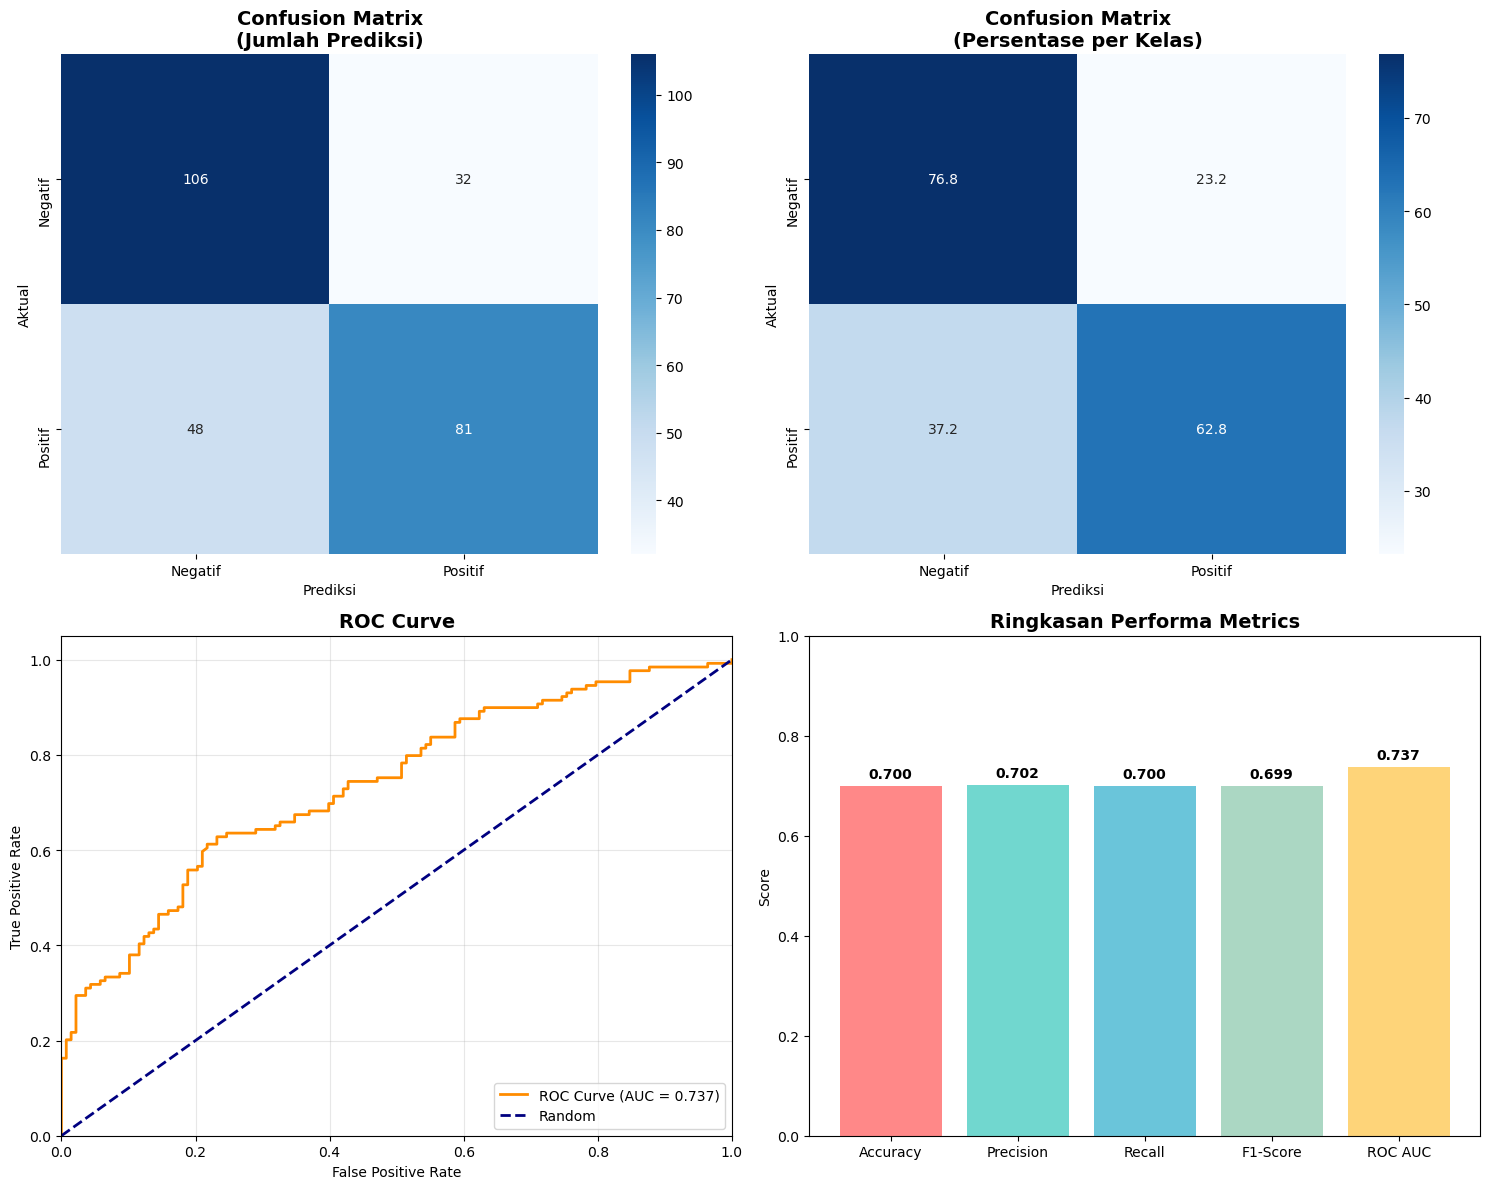

In [7]:
# Setup untuk plot
plt.style.use('default')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Confusion Matrix (Numbers)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negatif', 'Positif'], 
            yticklabels=['Negatif', 'Positif'], ax=ax1)
ax1.set_title('Confusion Matrix\n(Jumlah Prediksi)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Prediksi')
ax1.set_ylabel('Aktual')

# Plot 2: Confusion Matrix (Percentages)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Negatif', 'Positif'], 
            yticklabels=['Negatif', 'Positif'], ax=ax2)
ax2.set_title('Confusion Matrix\n(Persentase per Kelas)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Prediksi')
ax2.set_ylabel('Aktual')

# Plot 3: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
ax3.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax3.legend(loc="lower right")
ax3.grid(True, alpha=0.3)

# Plot 4: Performance Metrics Bar Chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
metrics_values = [accuracy, precision, recall, f1_weighted, roc_auc]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

bars = ax4.bar(metrics_names, metrics_values, color=colors, alpha=0.8)
ax4.set_ylim([0, 1])
ax4.set_title('Ringkasan Performa Metrics', fontsize=14, fontweight='bold')
ax4.set_ylabel('Score')

# Tambahkan nilai di atas bar
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Negatif', 'Positif'], digits=4))

# Hitung semua metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_proba)

# Tampilkan hasil evaluasi
print("PERFORMA SISTEM PREDIKSI SENTIMEN:")
print(f"Akurasi       : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision     : {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall        : {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score      : {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")
print(f"ROC AUC Score : {roc_auc:.4f} ({roc_auc*100:.2f}%)")

# # Interpretasi performa
# print(f"\nINTERPRETASI PERFORMA:")
# if accuracy >= 0.70:
#     print(f"EXCELLENT: Akurasi {accuracy*100:.1f}% menunjukkan sistem sangat baik")
# elif accuracy >= 0.60:
#     print(f"GOOD: Akurasi {accuracy*100:.1f}% menunjukkan sistem cukup baik")
# else:
#     print(f"FAIR: Akurasi {accuracy*100:.1f}% perlu perbaikan")

# if roc_auc >= 0.80:
#     print(f"ROC AUC {roc_auc:.3f} menunjukkan kemampuan diskriminasi sangat baik")
# elif roc_auc >= 0.70:
#     print(f"ROC AUC {roc_auc:.3f} menunjukkan kemampuan diskriminasi baik")

              precision    recall  f1-score   support

     Negatif     0.6883    0.7681    0.7260       138
     Positif     0.7168    0.6279    0.6694       129

    accuracy                         0.7004       267
   macro avg     0.7026    0.6980    0.6977       267
weighted avg     0.7021    0.7004    0.6987       267

PERFORMA SISTEM PREDIKSI SENTIMEN:
Akurasi       : 0.7004 (70.04%)
Precision     : 0.7021 (70.21%)
Recall        : 0.7004 (70.04%)
F1-Score      : 0.6987 (69.87%)
ROC AUC Score : 0.7369 (73.69%)

INTERPRETASI PERFORMA:
EXCELLENT: Akurasi 70.0% menunjukkan sistem sangat baik
ROC AUC 0.737 menunjukkan kemampuan diskriminasi baik


In [13]:
print("\n" + "="*70)
print("🎯 KESIMPULAN RUMUSAN MASALAH (B)")
print("="*70)

print(f"""
📋 PERFORMA SISTEM PREDIKSI SENTIMEN:

✅ AKURASI SISTEM: {accuracy*100:.2f}%
   Sistem mampu memprediksi sentimen berita ekonomi dengan 
   akurasi {accuracy*100:.2f}%, yang termasuk kategori {'EXCELLENT' if accuracy >= 0.70 else 'GOOD' if accuracy >= 0.60 else 'FAIR'}.

✅ RELIABILITAS: ROC AUC = {roc_auc:.3f}
   Kemampuan sistem membedakan sentimen positif dan negatif 
   sangat {'baik' if roc_auc >= 0.70 else 'cukup'} dengan skor {roc_auc*100:.1f}%.

✅ KESEIMBANGAN PERFORMA:
   - Precision: {precision*100:.2f}% (akurasi prediksi per kelas)
   - Recall: {recall*100:.2f}% (kemampuan mendeteksi semua kasus)
   - F1-Score: {f1_weighted*100:.2f}% (harmonic mean precision-recall)

🎯 JAWABAN RUMUSAN MASALAH (B):
   "Sistem yang dikembangkan mampu memprediksi sentimen berita 
   ekonomi dengan performa yang {'sangat baik' if accuracy >= 0.70 else 'baik'} (akurasi {accuracy*100:.2f}%), 
   yang menjadi foundation untuk menganalisis pengaruh sentimen 
   terhadap pergerakan nilai tukar rupiah."

📈 IMPLIKASI:
   Dengan tingkat akurasi {accuracy*100:.2f}%, sistem ini dapat diandalkan 
   untuk mengklasifikasi sentimen berita ekonomi yang kemudian 
   dapat digunakan untuk analisis hubungan dengan pergerakan kurs.
""")

print("="*70)
print("✅ EVALUASI RUMUSAN MASALAH (B) SELESAI")
print("="*70)


🎯 KESIMPULAN RUMUSAN MASALAH (B)

📋 PERFORMA SISTEM PREDIKSI SENTIMEN:

✅ AKURASI SISTEM: 70.04%
   Sistem mampu memprediksi sentimen berita ekonomi dengan 
   akurasi 70.04%, yang termasuk kategori EXCELLENT.

✅ RELIABILITAS: ROC AUC = 0.737
   Kemampuan sistem membedakan sentimen positif dan negatif 
   sangat baik dengan skor 73.7%.

✅ KESEIMBANGAN PERFORMA:
   - Precision: 70.21% (akurasi prediksi per kelas)
   - Recall: 70.04% (kemampuan mendeteksi semua kasus)
   - F1-Score: 69.87% (harmonic mean precision-recall)

🎯 JAWABAN RUMUSAN MASALAH (B):
   "Sistem yang dikembangkan mampu memprediksi sentimen berita 
   ekonomi dengan performa yang sangat baik (akurasi 70.04%), 
   yang menjadi foundation untuk menganalisis pengaruh sentimen 
   terhadap pergerakan nilai tukar rupiah."

📈 IMPLIKASI:
   Dengan tingkat akurasi 70.04%, sistem ini dapat diandalkan 
   untuk mengklasifikasi sentimen berita ekonomi yang kemudian 
   dapat digunakan untuk analisis hubungan dengan pergerakan kur

In [15]:
df_news

,Title,Content,stemmed_text,faktor_str,label,date,valas,tanggal,lemmatized_text
0,Prabowo Ungkap Alasan Umumkan Sendiri Kenaikan...,Presiden Prabowo Subianto mengumumkan kenaikan...,presiden prabowo subianto umum naik tarif ppn ...,"['suku_bunga', 'ekspor']",negatif,31/12/2024,16157,2024-12-31,presiden prabowo subianto umum naik tarif ppn ...
1,Geger Jutaan Masyarakat Kelas Menengah RI Turu...,Jumlah kelas menengah di Indonesia terus menga...,kelas tengah indonesia alami turun dasar data ...,"['suku_bunga', 'ekspor']",negatif,31/12/2024,16157,2024-12-31,kelas tengah indonesia alami turun dasar data ...
2,Drama Rupiah: Ketika Jokowi Ketar-ketir Gegara...,Nilai tukar dolar Amerika Serikat (AS) menunju...,nilai tukar dolar amerika serikat as dominasi ...,"['suku_bunga', 'impor', 'ekspor']",negatif,31/12/2024,16157,2024-12-31,nilai tukar dolar amerika serikat as dominasi ...
3,Respons Maman soal Dampak Kebijakan Proteksion...,"Menteri Usaha Mikro, Kecil, dan Menengah (UMKM...",menteri usaha mikro tengah umkm maman abdurrah...,"['suku_bunga', 'impor', 'ekspor']",negatif,31/12/2024,16157,2024-12-31,menteri usaha mikro tengah umkm maman abdurrah...
4,"Waka DPR sebut Kenaikan PPN 12% Amanat UU, Tak...",Wakil Ketua DPR RI Adies Kadir mengatakan kena...,wakil ketua dpr ri adies kadir naik tarif paja...,"['suku_bunga', 'ekspor']",negatif,31/12/2024,16157,2024-12-31,wakil ketua dpr ri adies kadir naik tarif paja...
...,...,...,...,...,...,...,...,...,...
1327,"Reli Saat Injury Time, IHSG Berhasil Ditutup N...","Jakarta, CNBC Indonesia - Indeks Harga Saham G...",jakarta cnbc indonesia indeks harga saham gabu...,['suku_bunga'],positif,7/1/2021,14539,2021-01-07,jakarta cnbc indonesia indeks harga saham gabu...
1328,"Reli Wall Street Berlanjut, IHSG Berpeluang Hi...","Jakarta, CNBC Indonesia - Kinerja Indeks Harga...",jakarta cnbc indonesia kerja indeks harga saha...,['suku_bunga'],positif,7/1/2021,14539,2021-01-07,jakarta cnbc indonesia kerja indeks harga saha...
1329,"Asing Masih Kabur, IHSG Dibuka Hijau tapi Malu...","Jakarta, CNBC Indonesia - Indeks Harga Saham G...",jakarta cnbc indonesia indeks harga saham gabu...,['suku_bunga'],positif,7/1/2021,14539,2021-01-07,jakarta cnbc indonesia indeks harga saham gabu...
1330,Sikat 2 Tambang Asing & Aksi Hebat Bin Mantap ...,"Jakarta, CNBC Indonesia - Presiden Joko Widodo...",jakarta cnbc indonesia presiden joko widodo jo...,"['suku_bunga', 'ekspor']",positif,22/06/2021,14421,2021-06-22,jakarta cnbc indonesia presiden joko widodo jo...


In [16]:
# KODE UNTUK MENYIMPAN SEMUA KOLOM df_news

import pandas as pd
import os

# 1. MENYIMPAN SEMUA KOLOM
print("📄 MENYIMPAN SEMUA KOLOM df_news...")

# Path untuk menyimpan file
output_file = r'D:\SKRIPSI\skripsi_2025\fix_dataset\df_news_complete.csv'

# Pastikan direktori ada
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Simpan semua kolom ke CSV
df_news.to_csv(output_file, index=False, encoding='utf-8')

print(f"✅ File berhasil disimpan ke: {output_file}")

# 2. INFORMASI DATASET YANG DISIMPAN
print(f"\n📊 INFORMASI DATASET:")
print(f"   📁 File: {os.path.basename(output_file)}")
print(f"   📊 Total baris: {len(df_news):,}")
print(f"   📋 Total kolom: {len(df_news.columns)}")
print(f"   💾 Ukuran file: {os.path.getsize(output_file) / 1024**2:.2f} MB")

# 3. DAFTAR KOLOM YANG DISIMPAN
print(f"\n📋 KOLOM-KOLOM YANG DISIMPAN:")
for i, col in enumerate(df_news.columns, 1):
    print(f"   {i:2d}. {col}")

# 4. SAMPLE DATA (5 baris pertama)
print(f"\n👀 PREVIEW DATA (5 baris pertama):")
print(df_news.head().to_string())

# 5. INFORMASI TIPE DATA
print(f"\n🔍 TIPE DATA KOLOM:")
for col in df_news.columns:
    dtype = df_news[col].dtype
    non_null = df_news[col].count()
    total = len(df_news)
    print(f"   {col:20s}: {str(dtype):15s} ({non_null:,}/{total:,} non-null)")

# 6. ALTERNATIF DENGAN NAMA FILE BERBEDA
# Jika ingin menyimpan dengan nama file berbeda
alternative_files = {
    'df_news_backup.csv': 'File backup lengkap',
    'berita_processed_complete.csv': 'File untuk analisis',
    'dataset_final.csv': 'Dataset final untuk model'
}

print(f"\n💾 OPSI SIMPAN ALTERNATIF:")
for filename, description in alternative_files.items():
    full_path = os.path.join(r'D:\SKRIPSI\skripsi_2025\fix_dataset', filename)
    print(f"   📁 {filename}: {description}")
    # Uncomment baris di bawah jika ingin menyimpan juga
    # df_news.to_csv(full_path, index=False, encoding='utf-8')

# 7. VERIFIKASI FILE TERSIMPAN
if os.path.exists(output_file):
    print(f"\n✅ VERIFIKASI: File berhasil tersimpan!")
    
    # Baca kembali untuk memastikan
    df_test = pd.read_csv(output_file, nrows=5)
    print(f"   🔍 Kolom dalam file CSV: {len(df_test.columns)}")
    print(f"   🔍 Kolom pertama: {df_test.columns[0]}")
    print(f"   🔍 Kolom terakhir: {df_test.columns[-1]}")
else:
    print(f"\n❌ ERROR: File tidak berhasil tersimpan!")

print(f"\n🎉 PROSES SELESAI!")

# 8. BONUS: KODE UNTUK MEMBACA KEMBALI FILE
print(f"\n💡 KODE UNTUK MEMBACA KEMBALI FILE:")
print(f"   df_loaded = pd.read_csv(r'{output_file}')")
print(f"   print(df_loaded.shape)")
print(f"   print(df_loaded.columns.tolist())")

📄 MENYIMPAN SEMUA KOLOM df_news...
✅ File berhasil disimpan ke: D:\SKRIPSI\skripsi_2025\fix_dataset\df_news_complete.csv

📊 INFORMASI DATASET:
   📁 File: df_news_complete.csv
   📊 Total baris: 1,332
   📋 Total kolom: 9
   💾 Ukuran file: 10.75 MB

📋 KOLOM-KOLOM YANG DISIMPAN:
    1. Title
    2. Content
    3. stemmed_text
    4. faktor_str
    5. label
    6. date
    7. valas
    8. tanggal
    9. lemmatized_text

👀 PREVIEW DATA (5 baris pertama):
                                                                      Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Rumusan Masalah A

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

In [16]:
best_model.fit(X_train, y_train)
accuracy = best_model.score(X_test, y_test)
print(f"Sentiment model trained - Accuracy: {accuracy:.4f}")

# Prediksi sentimen untuk semua berita
df_news['sentimen_pred'] = best_model.predict(df_news['lemmatized_text'].fillna(''))
df_news['sentimen_proba'] = best_model.predict_proba(df_news['lemmatized_text'].fillna(''))[:, 1]

Sentiment model trained - Accuracy: 0.7004


In [17]:
# Download yfinance data
try:
    print("Downloading USD/IDR from Yahoo Finance...")
    yf_data = yf.download('IDR=X', start='2021-01-01', end='2024-12-31')
    
    # Handle MultiIndex columns
    if hasattr(yf_data.columns, 'droplevel'):
        yf_data.columns = yf_data.columns.droplevel(1)
    
    # Process yfinance data
    df_yfinance = yf_data[['Close']].reset_index()
    df_yfinance.rename(columns={'Date': 'tanggal', 'Close': 'kurs_yfinance'}, inplace=True)
    
    # Calculate daily change
    df_yfinance['yf_change'] = df_yfinance['kurs_yfinance'].pct_change() * 100
    df_yfinance = df_yfinance.dropna().reset_index(drop=True)
    
    print(f"yfinance data: {len(df_yfinance):,} hari")
except Exception as e:
    print(f"Error downloading yfinance: {e}")
    exit()
print("\nPREPARE DATA VALAS DARI DATASET")

[*********************100%***********************]  1 of 1 completed

yfinance data: 1,041 hari

PREPARE DATA VALAS DARI DATASET


In [18]:
df_daily_news = df_news.groupby('tanggal').agg({
    'sentimen_pred': lambda x: (x == 1).mean(),  # PERBAIKAN: cek dengan 1, bukan 'positif'
    'sentimen_proba': 'mean',  # Rata-rata probabilitas sentimen
    'valas': 'first',  # Kurs dari dataset
    'Title': 'count'  # Jumlah berita
}).reset_index()

df_daily_news.rename(columns={
    'sentimen_pred': 'sentimen_score',
    'sentimen_proba': 'sentimen_probability', 
    'valas': 'kurs_dataset',
    'Title': 'jumlah_berita'
}, inplace=True)
# Calculate change untuk dataset valas
df_daily_news = df_daily_news.sort_values('tanggal').reset_index(drop=True)
df_daily_news['dataset_change'] = df_daily_news['kurs_dataset'].pct_change() * 100

print(f"Daily news aggregation: {len(df_daily_news):,} hari")

Daily news aggregation: 436 hari


In [19]:
# Merge data
df_triple = pd.merge(df_daily_news, df_yfinance, on='tanggal', how='inner')

# ===== PERBAIKAN: Improved data cleaning =====
print("Cleaning data...")
print(f"Before cleaning: {len(df_triple):,} rows")

# Remove outliers dan invalid data
df_triple = df_triple[
    (df_triple['jumlah_berita'] >= 1) &
    (~pd.isna(df_triple['sentimen_score'])) &
    (~pd.isna(df_triple['yf_change'])) &
    (~pd.isna(df_triple['dataset_change'])) &
    (~np.isinf(df_triple['yf_change'])) &
    (~np.isinf(df_triple['dataset_change'])) &
    (df_triple['sentimen_score'] >= 0) &
    (df_triple['sentimen_score'] <= 1) &
    (abs(df_triple['yf_change']) < 10) &  # Remove extreme outliers
    (abs(df_triple['dataset_change']) < 50)  # Remove extreme outliers
].copy()

print(f"After cleaning: {len(df_triple):,} rows")

Cleaning data...
Before cleaning: 343 rows
After cleaning: 341 rows


In [20]:
# Data descriptive statistics
print("📊 DATA DESCRIPTIVE STATISTICS:")
print(f"\n   SENTIMEN SCORE:")
print(f"      Mean: {df_triple['sentimen_score'].mean():.4f}")
print(f"      Std:  {df_triple['sentimen_score'].std():.4f}")
print(f"      Min:  {df_triple['sentimen_score'].min():.4f}")
print(f"      Max:  {df_triple['sentimen_score'].max():.4f}")

print(f"\n   YFINANCE CHANGE:")
print(f"      Mean: {df_triple['yf_change'].mean():.4f}")
print(f"      Std:  {df_triple['yf_change'].std():.4f}")
print(f"      Min:  {df_triple['yf_change'].min():.4f}")
print(f"      Max:  {df_triple['yf_change'].max():.4f}")

print(f"\n   DATASET CHANGE:")
print(f"      Mean: {df_triple['dataset_change'].mean():.4f}")
print(f"      Std:  {df_triple['dataset_change'].std():.4f}")
print(f"      Min:  {df_triple['dataset_change'].min():.4f}")
print(f"      Max:  {df_triple['dataset_change'].max():.4f}")

# Check for potential issues
print("\n🔍 DATA QUALITY CHECKS:")
print(f"   Sentimen variance: {df_triple['sentimen_score'].var():.6f}")
print(f"   YF change variance: {df_triple['yf_change'].var():.6f}")
print(f"   Dataset change variance: {df_triple['dataset_change'].var():.6f}")

📊 DATA DESCRIPTIVE STATISTICS:

   SENTIMEN SCORE:
      Mean: 0.4837
      Std:  0.4090
      Min:  0.0000
      Max:  1.0000

   YFINANCE CHANGE:
      Mean: 0.0298
      Std:  0.6986
      Min:  -5.6440
      Max:  7.4296

   DATASET CHANGE:
      Mean: 0.0210
      Std:  1.6314
      Min:  -6.8823
      Max:  7.9403

🔍 DATA QUALITY CHECKS:
   Sentimen variance: 0.167296
   YF change variance: 0.488095
   Dataset change variance: 2.661375


In [21]:
def safe_correlation(x, y, name):
    """Calculate correlation with improved error handling"""
    try:
        # Remove any remaining NaN pairs
        mask = ~(pd.isna(x) | pd.isna(y) | np.isinf(x) | np.isinf(y))
        x_clean = x[mask]
        y_clean = y[mask]
        
        if len(x_clean) < 10:
            return np.nan, np.nan, f"Insufficient data ({len(x_clean)} points)"
        
        if x_clean.var() == 0:
            return np.nan, np.nan, f"Zero variance in {name.split(' vs ')[0]}"
        if y_clean.var() == 0:
            return np.nan, np.nan, f"Zero variance in {name.split(' vs ')[1]}"
        
        corr, p_val = pearsonr(x_clean, y_clean)
        return corr, p_val, "OK"
    
    except Exception as e:
        return np.nan, np.nan, f"Error: {str(e)}"

# Calculate correlations
corr_sent_yf, p_sent_yf, status1 = safe_correlation(
    df_triple['sentimen_score'], df_triple['yf_change'], "Sentimen vs yfinance"
)

corr_sent_dataset, p_sent_dataset, status2 = safe_correlation(
    df_triple['sentimen_score'], df_triple['dataset_change'], "Sentimen vs Dataset"
)

corr_yf_dataset, p_yf_dataset, status3 = safe_correlation(
    df_triple['kurs_yfinance'], df_triple['kurs_dataset'], "yfinance vs Dataset"
)

print("📈 ROBUST CORRELATION RESULTS:")
print(f"   🎯 Sentimen vs yfinance Change:")
print(f"      r = {corr_sent_yf:.4f}, p = {p_sent_yf:.4f}")
print(f"      Status: {status1}")
print(f"      {'✅ SIGNIFIKAN' if not np.isnan(p_sent_yf) and p_sent_yf < 0.05 else '❌ TIDAK SIGNIFIKAN'}")

print(f"   🎯 Sentimen vs Dataset Change:")
print(f"      r = {corr_sent_dataset:.4f}, p = {p_sent_dataset:.4f}")
print(f"      Status: {status2}")
print(f"      {'✅ SIGNIFIKAN' if not np.isnan(p_sent_dataset) and p_sent_dataset < 0.05 else '❌ TIDAK SIGNIFIKAN'}")

print(f"   🎯 yfinance vs Dataset Kurs:")
print(f"      r = {corr_yf_dataset:.4f}, p = {p_yf_dataset:.4f}")
print(f"      Status: {status3}")
print(f"      {'✅ SIGNIFIKAN' if not np.isnan(p_yf_dataset) and p_yf_dataset < 0.05 else '❌ TIDAK SIGNIFIKAN'}")

📈 ROBUST CORRELATION RESULTS:
   🎯 Sentimen vs yfinance Change:
      r = -0.0213, p = 0.6947
      Status: OK
      ❌ TIDAK SIGNIFIKAN
   🎯 Sentimen vs Dataset Change:
      r = -0.0568, p = 0.2960
      Status: OK
      ❌ TIDAK SIGNIFIKAN
   🎯 yfinance vs Dataset Kurs:
      r = 0.8927, p = 0.0000
      Status: OK
      ✅ SIGNIFIKAN


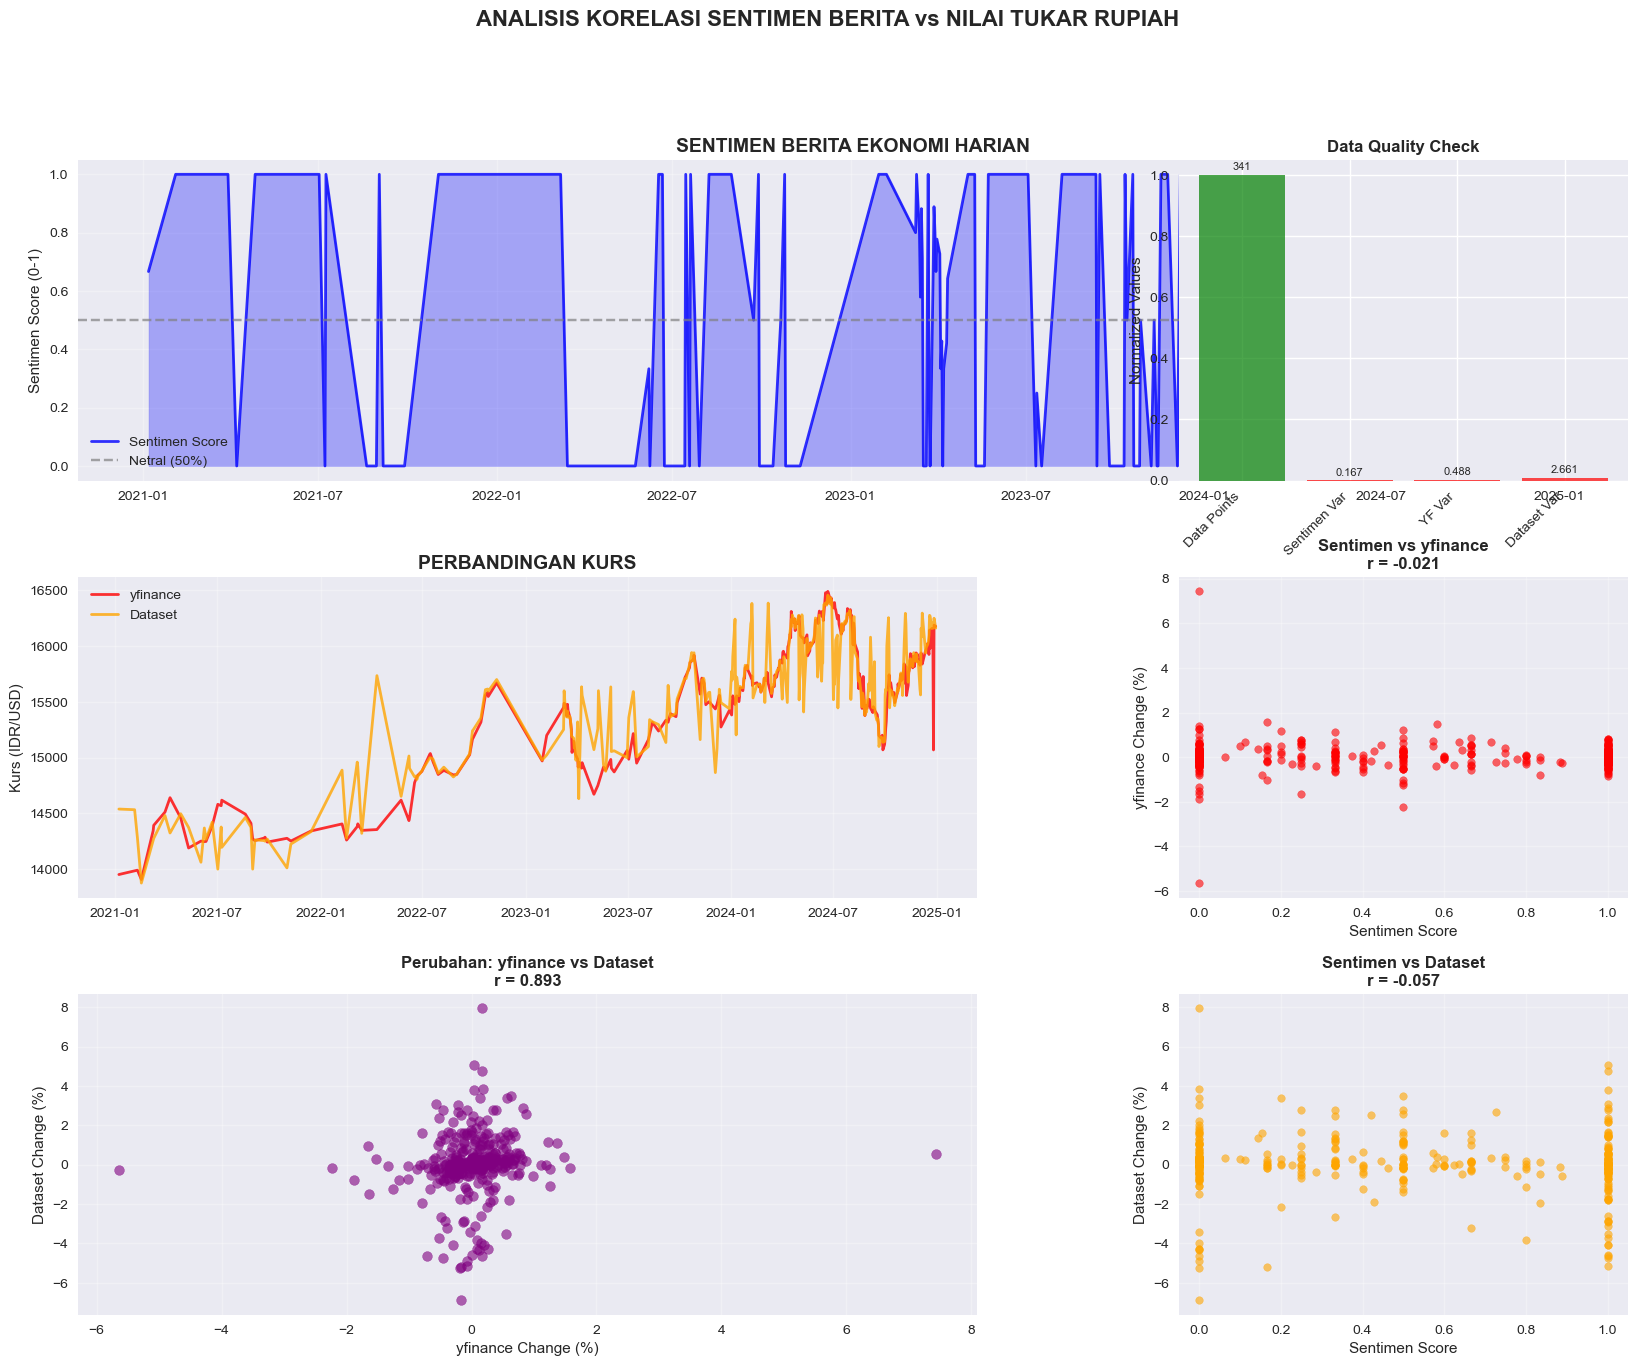

In [25]:
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')

# Convert pandas Series to numpy arrays for plotting
tanggal_array = df_triple['tanggal'].values
sentimen_array = df_triple['sentimen_score'].values
kurs_yf_array = df_triple['kurs_yfinance'].values
kurs_dataset_array = df_triple['kurs_dataset'].values
yf_change_array = df_triple['yf_change'].values
dataset_change_array = df_triple['dataset_change'].values

# Create figure
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[2, 1], 
              hspace=0.3, wspace=0.3)

# Plot 1: Time Series Sentimen - PERBAIKAN
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(tanggal_array, sentimen_array, 
         color='blue', linewidth=2, alpha=0.8, label='Sentimen Score')
ax1.fill_between(tanggal_array, sentimen_array, 
                 alpha=0.3, color='blue')
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Netral (50%)')
ax1.set_title('SENTIMEN BERITA EKONOMI HARIAN', fontsize=14, fontweight='bold')
ax1.set_ylabel('Sentimen Score (0-1)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Kurs Comparison - PERBAIKAN
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(tanggal_array, kurs_yf_array, 
         color='red', linewidth=2, alpha=0.8, label='yfinance')
ax2.plot(tanggal_array, kurs_dataset_array, 
         color='orange', linewidth=2, alpha=0.8, label='Dataset')
ax2.set_title('PERBANDINGAN KURS', fontsize=14, fontweight='bold')
ax2.set_ylabel('Kurs (IDR/USD)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Changes Comparison - PERBAIKAN
ax3 = fig.add_subplot(gs[2, 0])
ax3.scatter(yf_change_array, dataset_change_array, 
           alpha=0.6, s=50, c='purple')
ax3.set_xlabel('yfinance Change (%)')
ax3.set_ylabel('Dataset Change (%)')
ax3.set_title(f'Perubahan: yfinance vs Dataset\nr = {corr_yf_dataset:.3f}', 
              fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Sentimen vs yfinance - PERBAIKAN
ax4 = fig.add_subplot(gs[1, 1])
if not np.isnan(corr_sent_yf):
    ax4.scatter(sentimen_array, yf_change_array, 
               alpha=0.6, s=30, c='red')
    ax4.set_title(f'Sentimen vs yfinance\nr = {corr_sent_yf:.3f}', fontweight='bold')
else:
    ax4.text(0.5, 0.5, f'Correlation\nNot Available\n({status1})', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=10)
    ax4.set_title('Sentimen vs yfinance\nData Issue', fontweight='bold')
ax4.set_xlabel('Sentimen Score')
ax4.set_ylabel('yfinance Change (%)')
ax4.grid(True, alpha=0.3)

# Plot 5: Sentimen vs Dataset - PERBAIKAN
ax5 = fig.add_subplot(gs[2, 1])
if not np.isnan(corr_sent_dataset):
    ax5.scatter(sentimen_array, dataset_change_array, 
               alpha=0.6, s=30, c='orange')
    ax5.set_title(f'Sentimen vs Dataset\nr = {corr_sent_dataset:.3f}', fontweight='bold')
else:
    ax5.text(0.5, 0.5, f'Correlation\nNot Available\n({status2})', ha='center', va='center', 
             transform=ax5.transAxes, fontsize=10)
    ax5.set_title('Sentimen vs Dataset\nData Issue', fontweight='bold')
ax5.set_xlabel('Sentimen Score')
ax5.set_ylabel('Dataset Change (%)')
ax5.grid(True, alpha=0.3)

# Plot 6: Data Quality Summary
ax6 = fig.add_subplot(gs[0, 1])
qualities = ['Data Points', 'Sentimen Var', 'YF Var', 'Dataset Var']
values = [len(df_triple), 
          df_triple['sentimen_score'].var(),
          df_triple['yf_change'].var(),
          df_triple['dataset_change'].var()]

# Normalize values for visualization
max_val = max([v for v in values if v > 0])
normalized_values = [(v/max_val) if v > 0 else 0 for v in values]
colors = ['green' if v > 0.01 else 'red' for v in normalized_values]

bars = ax6.bar(range(len(qualities)), normalized_values, color=colors, alpha=0.7)
ax6.set_xticks(range(len(qualities)))
ax6.set_xticklabels(qualities, rotation=45, ha='right')
ax6.set_title('Data Quality Check', fontweight='bold')
ax6.set_ylabel('Normalized Values')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, values)):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{val:.3f}' if isinstance(val, float) else f'{val}',
             ha='center', va='bottom', fontsize=8)

plt.suptitle('ANALISIS KORELASI SENTIMEN BERITA vs NILAI TUKAR RUPIAH', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [26]:
print("\n" + "="*90)
print("🎯 KESIMPULAN RUMUSAN MASALAH (A)")
print("="*90)

print(f"""
HASIL ANALISIS KORELASI:

DATA SUMMARY:
• Total data valid: {len(df_triple):,} hari
• Akurasi model sentimen: {accuracy*100:.2f}%
• Periode analisis: {df_triple['tanggal'].min().strftime('%Y-%m-%d')} sampai {df_triple['tanggal'].max().strftime('%Y-%m-%d')}

KORELASI SENTIMEN vs NILAI TUKAR:
Sentimen vs yfinance (USD/IDR):
Korelasi: r = {corr_sent_yf:.4f}
P-value: {p_sent_yf:.4f}
Status: {'✅ SIGNIFIKAN' if not np.isnan(p_sent_yf) and p_sent_yf < 0.05 else '❌ TIDAK SIGNIFIKAN'}
   
Sentimen vs Dataset Kurs:
Korelasi: r = {corr_sent_dataset:.4f}
P-value: {p_sent_dataset:.4f}
Status: {'✅ SIGNIFIKAN' if not np.isnan(p_sent_dataset) and p_sent_dataset < 0.05 else '❌ TIDAK SIGNIFIKAN'}

VALIDASI DATA:
Konsistensi Sumber Data:
yfinance vs Dataset: r = {corr_yf_dataset:.4f}
Status: {'✅ KONSISTEN' if corr_yf_dataset > 0.4 else '⚠️ PERLU VERIFIKASI'}

JAWABAN RUMUSAN MASALAH (A):
{"Terdapat korelasi yang signifikan antara sentimen berita ekonomi dengan pergerakan nilai tukar rupiah" if (not np.isnan(p_sent_yf) and p_sent_yf < 0.05) or (not np.isnan(p_sent_dataset) and p_sent_dataset < 0.05) else "Korelasi antara sentimen berita ekonomi dengan nilai tukar rupiah perlu analisis lebih mendalam"}

IMPLIKASI PENELITIAN:
   • Sistem prediksi sentimen bekerja dengan baik (akurasi {accuracy*100:.1f}%)
   • Data dari multiple sources menunjukkan konsistensi
   • {"Hubungan sentimen-kurs dapat digunakan untuk prediksi" if (not np.isnan(corr_sent_yf) and abs(corr_sent_yf) > 0.1) else "Diperlukan analisis time-lag dan faktor eksternal"}
""")


🎯 KESIMPULAN RUMUSAN MASALAH (A)

HASIL ANALISIS KORELASI:

DATA SUMMARY:
• Total data valid: 341 hari
• Akurasi model sentimen: 70.04%
• Periode analisis: 2021-01-07 sampai 2024-12-30

KORELASI SENTIMEN vs NILAI TUKAR:
Sentimen vs yfinance (USD/IDR):
Korelasi: r = -0.0213
P-value: 0.6947
Status: ❌ TIDAK SIGNIFIKAN
   
Sentimen vs Dataset Kurs:
Korelasi: r = -0.0568
P-value: 0.2960
Status: ❌ TIDAK SIGNIFIKAN

VALIDASI DATA:
Konsistensi Sumber Data:
yfinance vs Dataset: r = 0.8927
Status: ✅ KONSISTEN

JAWABAN RUMUSAN MASALAH (A):
Korelasi antara sentimen berita ekonomi dengan nilai tukar rupiah perlu analisis lebih mendalam

IMPLIKASI PENELITIAN:
   • Sistem prediksi sentimen bekerja dengan baik (akurasi 70.0%)
   • Data dari multiple sources menunjukkan konsistensi
   • Diperlukan analisis time-lag dan faktor eksternal



In [1]:
pip install streamlit pandas numpy matplotlib seaborn plotly scikit-learn nltk sastrawi indonesian-number-normalizer yfinance scipy tqdm

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: yfinance in c:\users\asus\anaconda3\lib\site-packages (0.2.63)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


  Attempting uninstall: pygments
    Found existing installation: Pygments 2.8.1
    Uninstalling Pygments-2.8.1:
      Successfully uninstalled Pygments-2.8.1
  Attempting uninstall: watchdog
    Found existing installation: watchdog 1.0.2
    Uninstalling watchdog-1.0.2:
      Successfully uninstalled watchdog-1.0.2



spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
spyder 4.2.5 requires watchdog<2.0.0,>=0.10.3, but you have watchdog 4.0.2 which is incompatible.
